In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

from sklearn.preprocessing import MinMaxScaler, StandardScaler

import warnings
warnings.filterwarnings('ignore')

from scipy import stats
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional

import io
from google.colab import files

# Set random seed to get the same result after each time running the code
tf.random.set_seed(1234)

uploaded = files.upload()

Saving ercot_raw.csv to ercot_raw.csv


In [2]:
df = pd.read_csv(io.BytesIO(uploaded['ercot_raw.csv']))
# df = pd.read_csv('D202.csv')

df.rename(columns = {'Hour Ending':'date', 'ERCOT':'usage'}, inplace = True)

In [3]:
df['date'] = pd.to_datetime(df['date'])

df['usage'] = pd.to_numeric(df['usage'])
df.set_index('date',inplace=True)
df.head()

,usage
date,
2017-01-01 01:00:00,29420.64
2017-01-01 02:00:00,28870.81
2017-01-01 03:00:00,28211.72
2017-01-01 04:00:00,27820.29
2017-01-01 05:00:00,27628.96


In [4]:
#removing the last data point as it is 2020 data
df.drop(index=df.index[-1], 
        axis=0, 
        inplace=True)

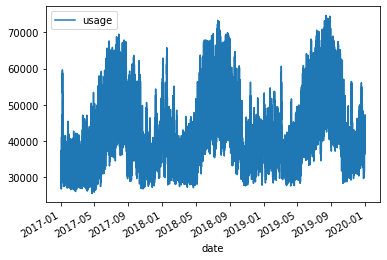

In [5]:
df.plot()

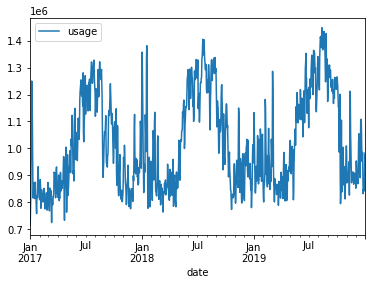

In [6]:
df_daily = df.resample('D').apply(sum)
df_daily.plot()

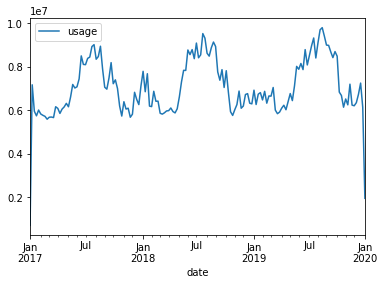

In [7]:
df_weekly = df.resample('W').apply(sum)
df_weekly.plot()

# Code

In [8]:
# Create input dataset
# Th input shape should be [samples, time steps, features]
def create_dataset (X, look_back = 1):
    Xs, ys = [], []
    
    for i in range(len(X)-look_back):
        v = X[i:i+look_back]
        Xs.append(v)
        ys.append(X[i+look_back])
        
    return np.array(Xs), np.array(ys)


In [9]:
def create_gru(units):
    model = Sequential()
    # Input layer 
    model.add(GRU (units = units, return_sequences = True, 
                 input_shape = [X_train.shape[1], X_train.shape[2]]))
    model.add(Dropout(0.15)) 
    # Hidden layer
    model.add(GRU(units = units))                 
    model.add(Dropout(0.15))
    model.add(Dense(units = 1)) 
    #Compile model
    model.compile(optimizer='adam',loss='mse')
   
    return model


def fit_model(model):
    early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                               patience = 10)
    history = model.fit(X_train, y_train, epochs = 100, validation_split = 0.2,
                    batch_size = 16, shuffle = False, callbacks = [early_stop])
    return history



In [10]:
def plot_loss (history, model_name):
    plt.figure(figsize = (10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Train vs Validation Loss for ' + model_name)
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')

# Make prediction
def prediction(model):
    prediction = model.predict(X_test)
    prediction = scaler.inverse_transform(prediction)
    return prediction

# Plot test data vs prediction
def plot_future(prediction, model_name, y_test):
    
    plt.figure(figsize=(10, 6))
    
    range_future = len(prediction)

    plt.plot(np.arange(range_future), np.array(y_test), label='Test data')
    plt.plot(np.arange(range_future), np.array(prediction),label='Prediction')

    plt.title('Test data vs prediction for ' + model_name)
    plt.legend(loc='upper left')
    plt.xlabel('Day')
    plt.ylabel('Electricity consumption')

In [11]:
# Calculate MAE and RMSE
def evaluate_prediction(predictions, actual, model_name):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()
    mape = np.mean(np.abs(errors/actual))*100

    print(model_name + ':')
    print('Mean Absolute Error: {:.4f}'.format(mae))
    print('Root Mean Square Error: {:.4f}'.format(rmse))
    print('Mean Absolute Percentage Error: {:.4f}'.format(mape))



# Daily Data

In [16]:
# Split train data and test data
train_size = round(len(df_daily)*0.666666)

# train_data = df.WC.loc[:train_size] -----> it gives a series
# Do not forget use iloc to select a number of rows
train_data = df_daily.iloc[:train_size]
test_data = df_daily.iloc[train_size:]

In [17]:
# Scale data
# The input to scaler.fit -> array-like, sparse matrix, dataframe of shape (n_samples, n_features)
scaler = MinMaxScaler().fit(train_data)

train_scaled = scaler.transform(train_data)
test_scaled = scaler.transform(test_data)

In [18]:
X_train, y_train = create_dataset(train_scaled,30)
X_test, y_test = create_dataset(test_scaled,30)

print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape) 
print('y_test.shape: ', y_test.shape)

X_train.shape:  (700, 30, 1)
y_train.shape:  (700, 1)
X_test.shape:  (335, 30, 1)
y_test.shape:  (335, 1)


In [19]:
model_gru = create_gru(64)
history_gru = fit_model(model_gru)

Epoch 1/100
35/35 [==============================] - 4s 42ms/step - loss: 0.0220 - val_loss: 0.0541
Epoch 2/100
35/35 [==============================] - 1s 20ms/step - loss: 0.0231 - val_loss: 0.0129
Epoch 3/100
35/35 [==============================] - 1s 21ms/step - loss: 0.0136 - val_loss: 0.0151
Epoch 4/100
35/35 [==============================] - 1s 19ms/step - loss: 0.0137 - val_loss: 0.0125
Epoch 5/100
35/35 [==============================] - 1s 19ms/step - loss: 0.0123 - val_loss: 0.0144
Epoch 6/100
35/35 [==============================] - 1s 19ms/step - loss: 0.0130 - val_loss: 0.0102
Epoch 7/100
35/35 [==============================] - 1s 22ms/step - loss: 0.0113 - val_loss: 0.0126
Epoch 8/100
35/35 [==============================] - 1s 20ms/step - loss: 0.0117 - val_loss: 0.0087
Epoch 9/100
35/35 [==============================] - 1s 19ms/step - loss: 0.0112 - val_loss: 0.0120
Epoch 10/100
35/35 [==============================] - 1s 19ms/step - loss: 0.0114 - val_loss: 0.0070

GRU:
Mean Absolute Error: 42431.4487
Root Mean Square Error: 58044.3262
Mean Absolute Percentage Error: 4.1162


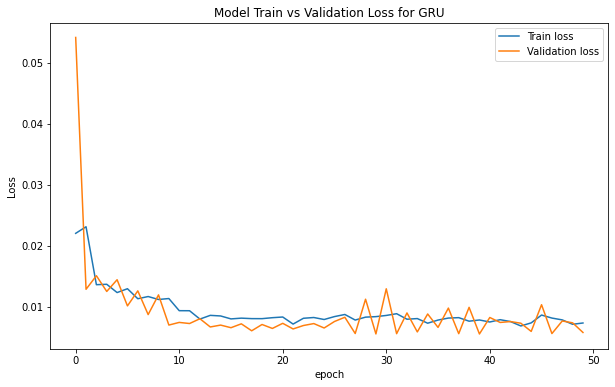

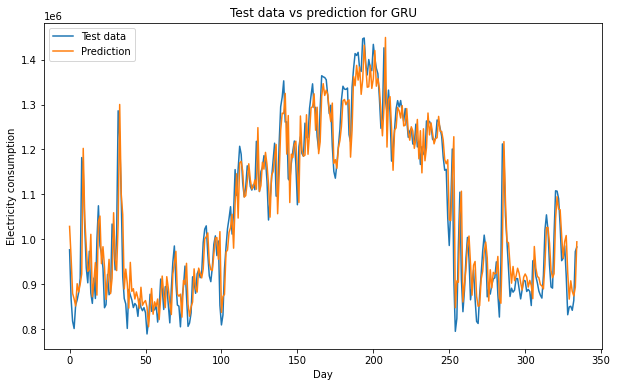

In [20]:
plot_loss (history_gru, 'GRU')

# Transform data back to original data space
y_test_orig = scaler.inverse_transform(y_test)
y_train_orig = scaler.inverse_transform(y_train)

prediction_gru = prediction(model_gru)

plot_future(prediction_gru, 'GRU', y_test_orig)

evaluate_prediction(prediction_gru, y_test_orig, 'GRU')

# Weekly Data

In [12]:
# Split train data and test data
train_size = round(len(df_weekly)*0.666666)

# train_data = df.WC.loc[:train_size] -----> it gives a series
# Do not forget use iloc to select a number of rows
train_data = df_weekly.iloc[:train_size]
test_data = df_weekly.iloc[train_size:]

In [13]:
# Scale data
# The input to scaler.fit -> array-like, sparse matrix, dataframe of shape (n_samples, n_features)
scaler = MinMaxScaler().fit(train_data)

train_scaled = scaler.transform(train_data)
test_scaled = scaler.transform(test_data)


X_train, y_train = create_dataset(train_scaled,30)
X_test, y_test = create_dataset(test_scaled,30)

print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape) 
print('y_test.shape: ', y_test.shape)

X_train.shape:  (75, 30, 1)
y_train.shape:  (75, 1)
X_test.shape:  (23, 30, 1)
y_test.shape:  (23, 1)


In [14]:
model_gru = create_gru(64)
history_gru = fit_model(model_gru)

Epoch 1/100
4/4 [==============================] - 7s 685ms/step - loss: 0.4625 - val_loss: 0.0791
Epoch 2/100
4/4 [==============================] - 0s 89ms/step - loss: 0.0593 - val_loss: 0.0415
Epoch 3/100
4/4 [==============================] - 0s 76ms/step - loss: 0.0566 - val_loss: 0.1124
Epoch 4/100
4/4 [==============================] - 0s 87ms/step - loss: 0.0677 - val_loss: 0.0266
Epoch 5/100
4/4 [==============================] - 0s 98ms/step - loss: 0.0162 - val_loss: 0.0037
Epoch 6/100
4/4 [==============================] - 0s 73ms/step - loss: 0.0207 - val_loss: 0.0063
Epoch 7/100
4/4 [==============================] - 0s 87ms/step - loss: 0.0213 - val_loss: 0.0048
Epoch 8/100
4/4 [==============================] - 0s 78ms/step - loss: 0.0136 - val_loss: 0.0038
Epoch 9/100
4/4 [==============================] - 0s 76ms/step - loss: 0.0105 - val_loss: 0.0084
Epoch 10/100
4/4 [==============================] - 0s 68ms/step - loss: 0.0117 - val_loss: 0.0128
Epoch 11/100
4/4 [

GRU:
Mean Absolute Error: 832569.1087
Root Mean Square Error: 1230520.2494
Mean Absolute Percentage Error: 18.4941


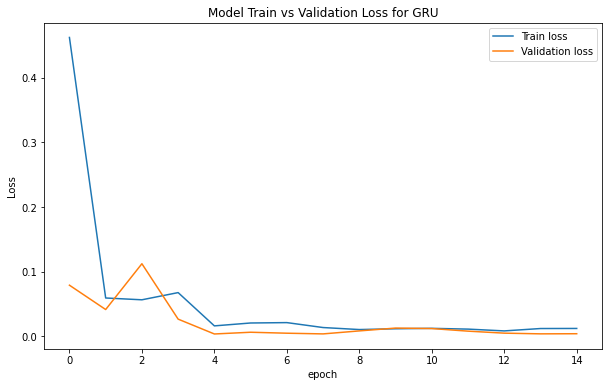

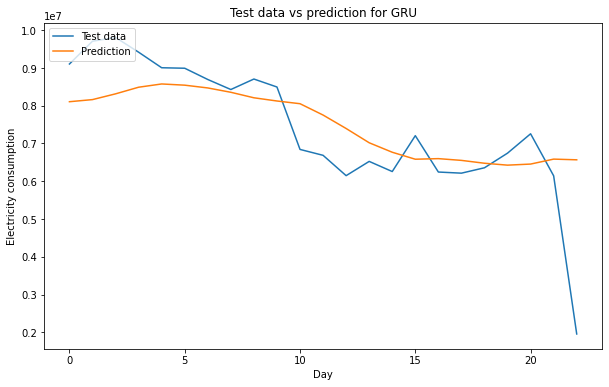

In [15]:
plot_loss (history_gru, 'GRU')

# Transform data back to original data space
y_test_orig = scaler.inverse_transform(y_test)
y_train_orig = scaler.inverse_transform(y_train)

prediction_gru = prediction(model_gru)

plot_future(prediction_gru, 'GRU', y_test_orig)

evaluate_prediction(prediction_gru, y_test_orig, 'GRU')